In [1]:
from __future__ import print_function
import os,sys,math
import matplotlib.pyplot as plt
nnscript = os.path.abspath('../../scripts')
sys.path.append(nnscript)
nnmodel = os.path.abspath('model')
sys.path.append(nnmodel)
from mnist_densenet import *
from keras.utils import plot_model
%matplotlib inline

Using TensorFlow backend.


In [2]:
model,x_train,y_train,x_test,y_test=main('mcu/weights.h')

60000 train samples
10000 test samples
x_train shape: (60000, 28, 28, 1)
data range 0.0 31.0
input_1
         max value: 31.0
         min value: 0.0
         dec bit 2
conv2d_1
         max value: 14.176423
         min value: -62.183807
         dec bit 1
lambda_1
         max value: 14.176423
         min value: -62.183807
         dec bit 1
re_lu_1
         max value: 14.176423
         min value: -62.183807
         dec bit 1
max_pooling2d_1
         max value: 14.176423
         min value: -62.183807
         dec bit 1
conv2d_2
         max value: 10.680136
         min value: -13.675631
         dec bit 3
lambda_2
         max value: 10.680136
         min value: -13.675631
         dec bit 3
re_lu_2
         max value: 10.680136
         min value: -13.675631
         dec bit 3
concatenate_1
         max value: 10.680136
         min value: -13.675631
         dec bit 3
conv2d_3
         max value: 10.60827
         min value: -19.366468
         dec bit 2
lambda_3
         max

In [3]:
plot_model(model, to_file='model.png', show_shapes=True)

In [4]:
def show(d, f, n=None):
    if(n==None):
        R = 1
    else:
        R = n
    for i in range(R):
        if(i%10==0):
            N = R-i
            if(N > 10): N = 10
            fig, axs = plt.subplots(1, N)
        I = i + f
        im = np.asarray(d[0][I]).reshape(28,28)
        try:
            ax = axs[i%N]
        except:
            ax = axs
        ax.imshow(im)
        label =  d[1][I].argmax()
        ax.set_title(label)

def RunSysCmd(cmd):
    import subprocess
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    (output, err) = p.communicate()
    p_status = p.wait()
    print(output.decode('utf-8'))

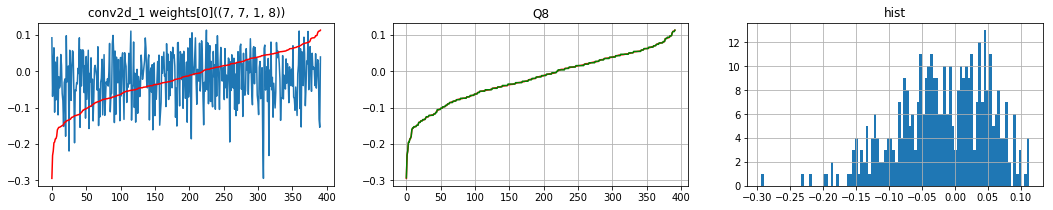

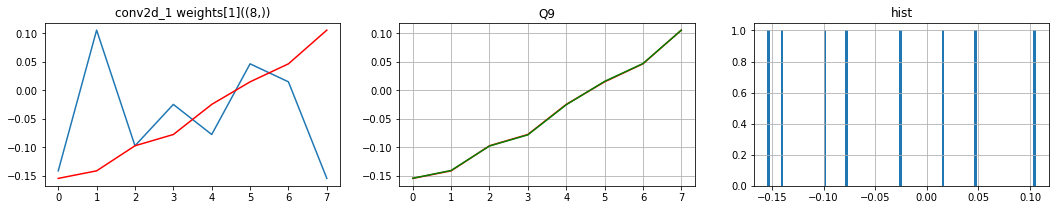

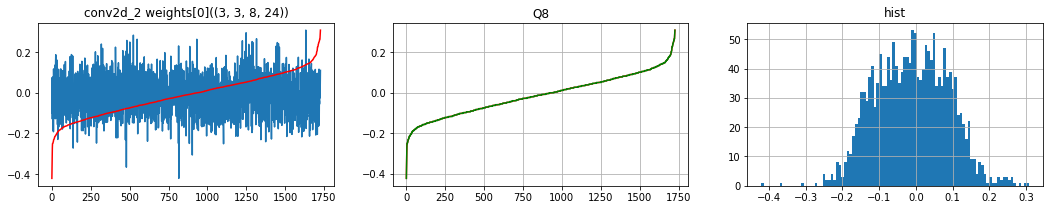

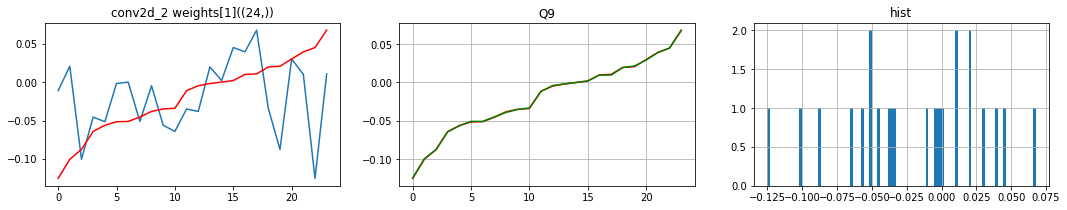

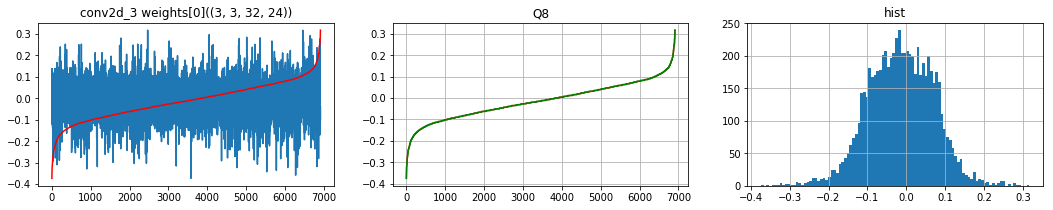

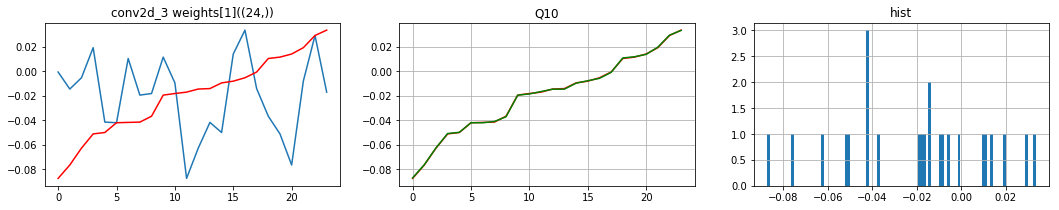

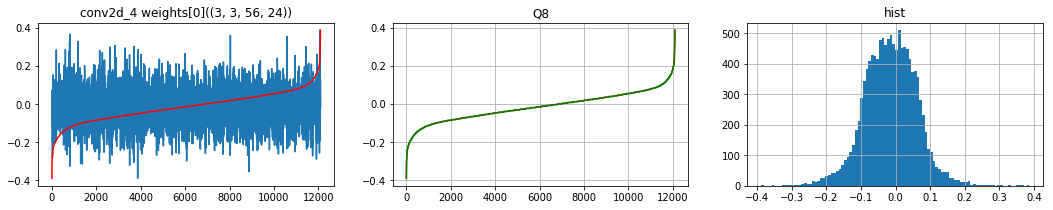

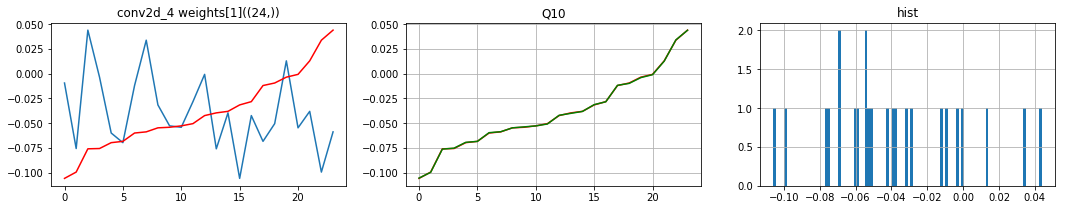

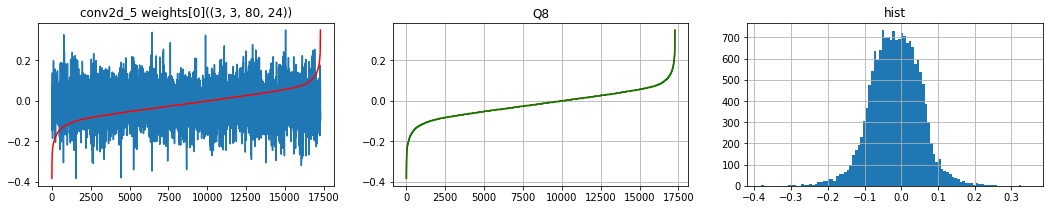

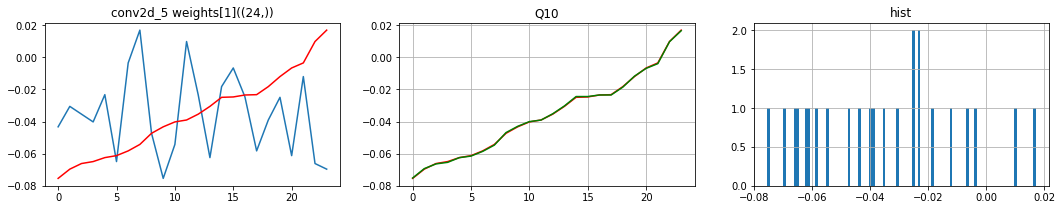

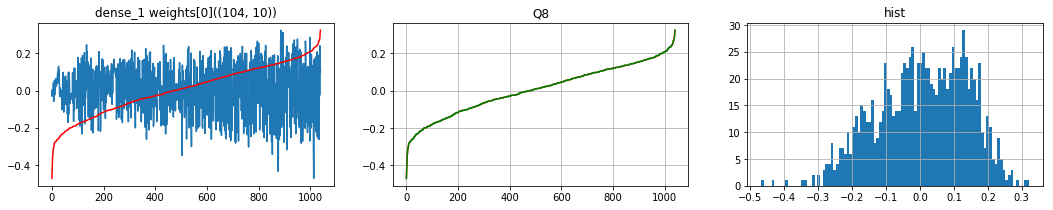

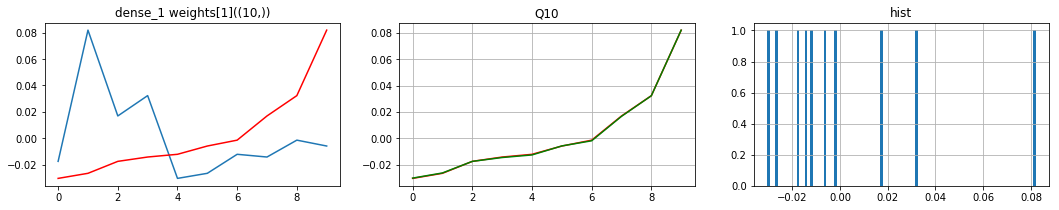

In [5]:
for layer in model.layers:
    for i, wt in enumerate(layer.get_weights()):
        show_weights(wt, '%s weights[%s](%s)'%(layer.name, i, wt.shape))

In [6]:
RunSysCmd('rm -fr tmp && mkdir tmp')
RunSysCmd('scons')


scons: Reading SConscript files ...
scons: done reading SConscript files.
scons: Building targets ...
scons: `.' is up to date.
scons: done building targets.



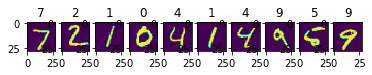

In [7]:
show((x_test,y_test), 0, 10)


INFO: Start compile...
Layer        Activation    output shape      ops          memory            mem life-time
----------------------------------------------------------------------------------------------
 Input      -          - (  28,  28,   1)        0   (  784,  784,    0)    1 - - -  - - - - 
 Conv2D     - ReLU     - (  28,  28,   8)   307328   (  784, 6272, 1568)    1 1 - -  - - - - 
 Maxpool    -          - (   7,   7,   8)        0   ( 6272,  392,    0)    1 - 1 -  - - - - 
 Conv2D     - ReLU     - (   7,   7,  24)    84672   (  392, 1176,  864)    1 5 - -  - - - - 
 Concat     -          - (   7,   7,  32)        0   ( 1568, 1568,    0)    - 4 4 -  - - - - 
 Conv2D     - ReLU     - (   7,   7,  24)   338688   ( 1568, 1176,  864)    1 3 3 1  - - - - 
 Concat     -          - (   7,   7,  56)        0   ( 2744, 2744,    0)    - 3 3 -  3 - - - 
 Conv2D     - ReLU     - (   7,   7,  24)   592704   ( 2744, 1176,  864)    1 2 2 1  2 - - - 
 Concat     -          - (   7,   7,  8

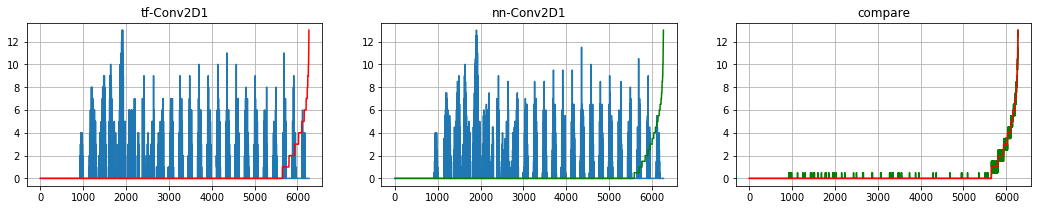

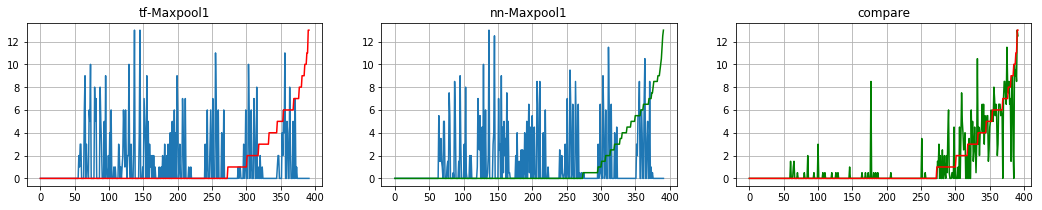

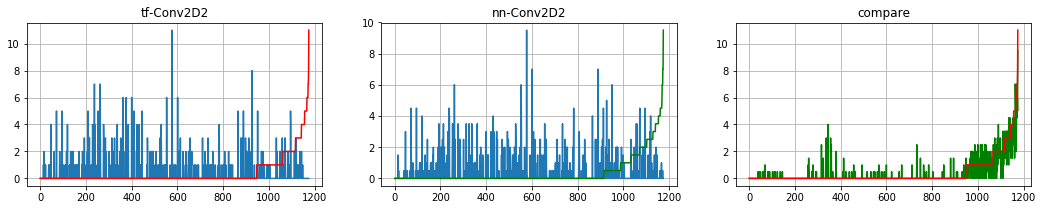

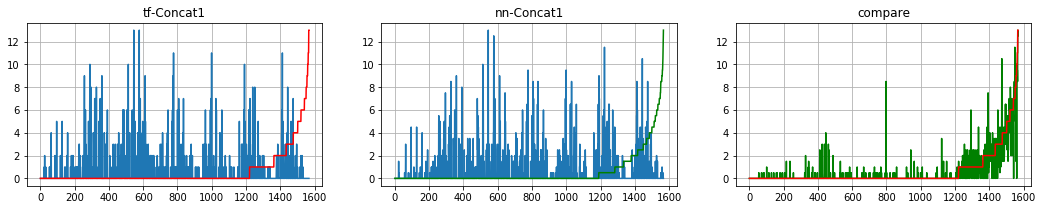

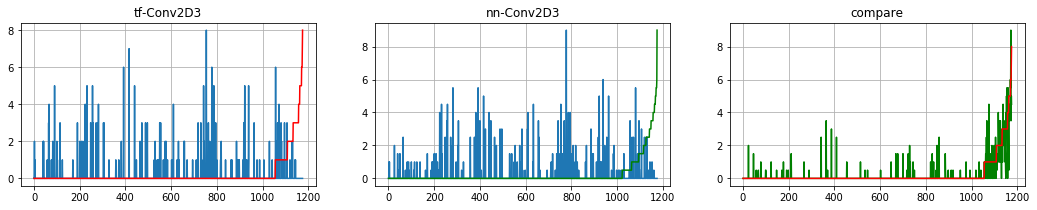

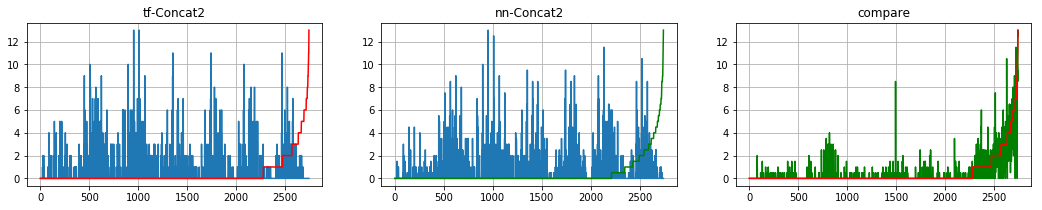

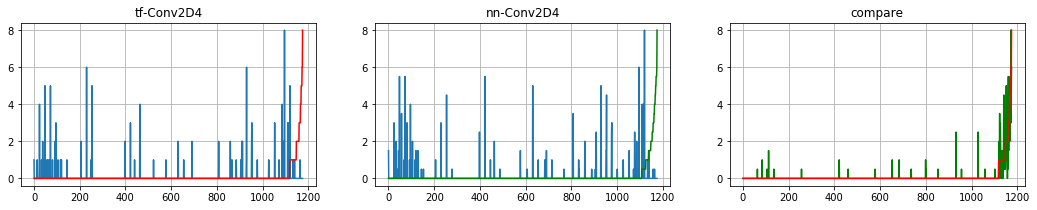

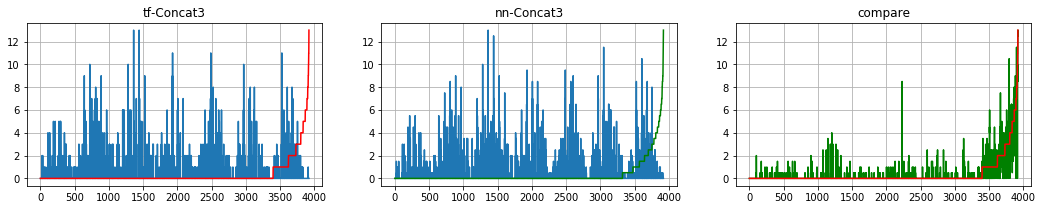

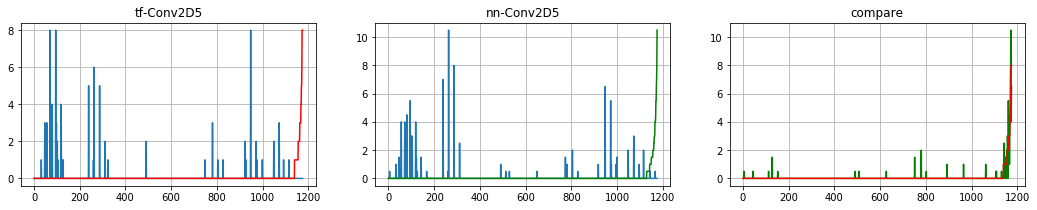

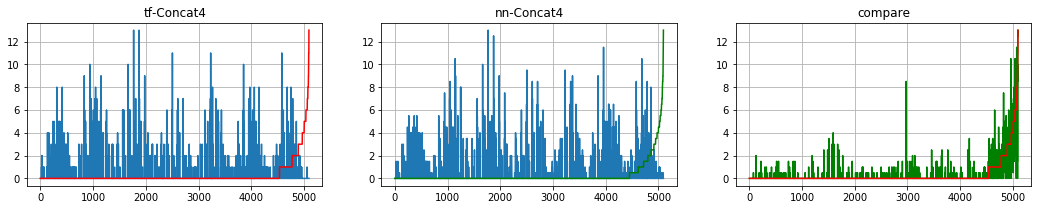

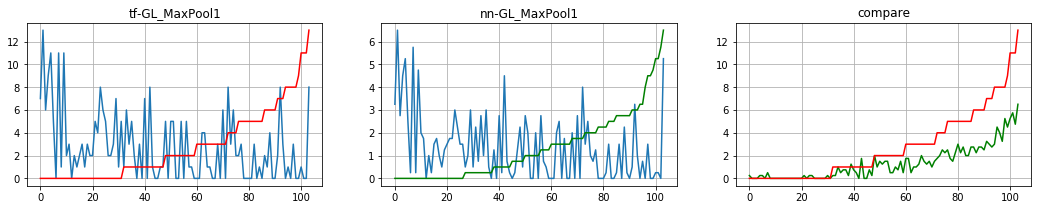

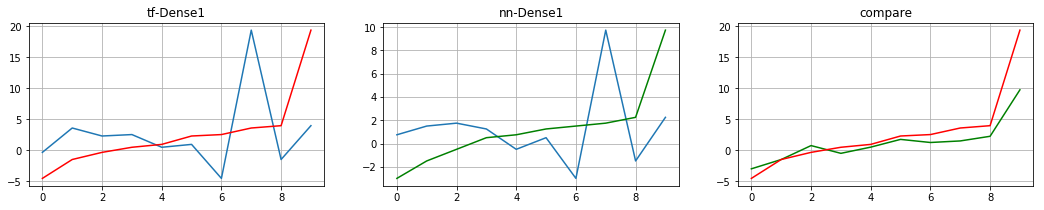

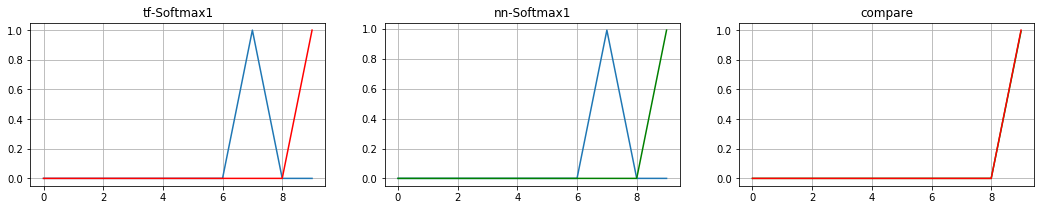

In [8]:
shift_list = eval(open('.shift_list').read())
index = 0
X = x_test[index]
X = X.reshape(1,28,28,1)
f2q(X, shift_list['input_1']).astype(np.int8).tofile('tmp/input.raw')
RunSysCmd('./mnist')
y = np.fromfile('tmp/Softmax1.raw',dtype=np.int8).argmax()
print('predic y is %d, expected %d'%(y, y_test[index].argmax()))

# name map from keras to nnom
lmp = { "re_lu_1":"Conv2D1",
        "max_pooling2d_1":"Maxpool1",
        "re_lu_2":"Conv2D2",
        "concatenate_1":"Concat1",
        "re_lu_3":"Conv2D3",
        "concatenate_2":"Concat2",
        "re_lu_4":"Conv2D4",
        "concatenate_3":"Concat3",
        "re_lu_5":"Conv2D5",
        "concatenate_4":"Concat4",
        "global_max_pooling2d_1":"GL_MaxPool1",
        "dropout_1":"Dropout1",
        "dense_1":"Dense1",
        "softmax_1":"Softmax1"}
print(shift_list)
for layer in model.layers[1:]:
    if('lambda_' in layer.name):continue
    if('conv2d' in layer.name):continue
    if('dropout' in layer.name):continue
    layer_model = Model(inputs=model.input, outputs=layer.output)
    outR = layer_model.predict(X)
    name= lmp[layer.name]
    Q = shift_list[layer.name]
    out = q2f(np.fromfile('tmp/%s.raw'%(name),dtype=np.int8),Q)
    compare(outR,out, name)

In [9]:
rP = 0
for i,im in enumerate(x_test):
    X = im.reshape(1,28,28,1)
    f2q(X, shift_list['input_1']).astype(np.int8).tofile('tmp/input.raw')
    if(0 == os.system('./mnist > /dev/null')):
        out = q2f(np.fromfile('tmp/Softmax1.raw',dtype=np.int8),7)
        out = np.asarray(out)
        num, prop = out.argmax(), out[out.argmax()]
        rnum = y_test[i].argmax()
        if((rnum == num) and (prop > 0.8)):
            #print('test image %d is %d, predict correctly with prop %s'%(i, rnum, prop))
            rP += 1
        if((i>0) and ((i%1000)==0)):
            print('%.1f%%(%s) out of %s is correct predicted'%(rP*100.0/i, rP, i))
            break

print('%.1f%%(%s) out of %s is correct predicted'%(rP*100.0/i, rP, i))

95.5%(955) out of 1000 is correct predicted
95.5%(955) out of 1000 is correct predicted
